In [252]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping

import shap

In [253]:
df = pd.read_csv('heart_disease_uci.csv')
df[:5]


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [254]:
# Unique values of heart disease  severity
unique_values = df['num'].unique()
unique_values

array([0, 2, 1, 3, 4])

In [255]:
# Unique values of medical institutes
unique_values = df['dataset'].unique()
unique_values

array(['Cleveland', 'Hungary', 'Switzerland', 'VA Long Beach'],
      dtype=object)

In [256]:
# print columns containng null values
columns_with_null = df.columns[df.isnull().any()]
print(columns_with_null)

Index(['trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak',
       'slope', 'ca', 'thal'],
      dtype='object')


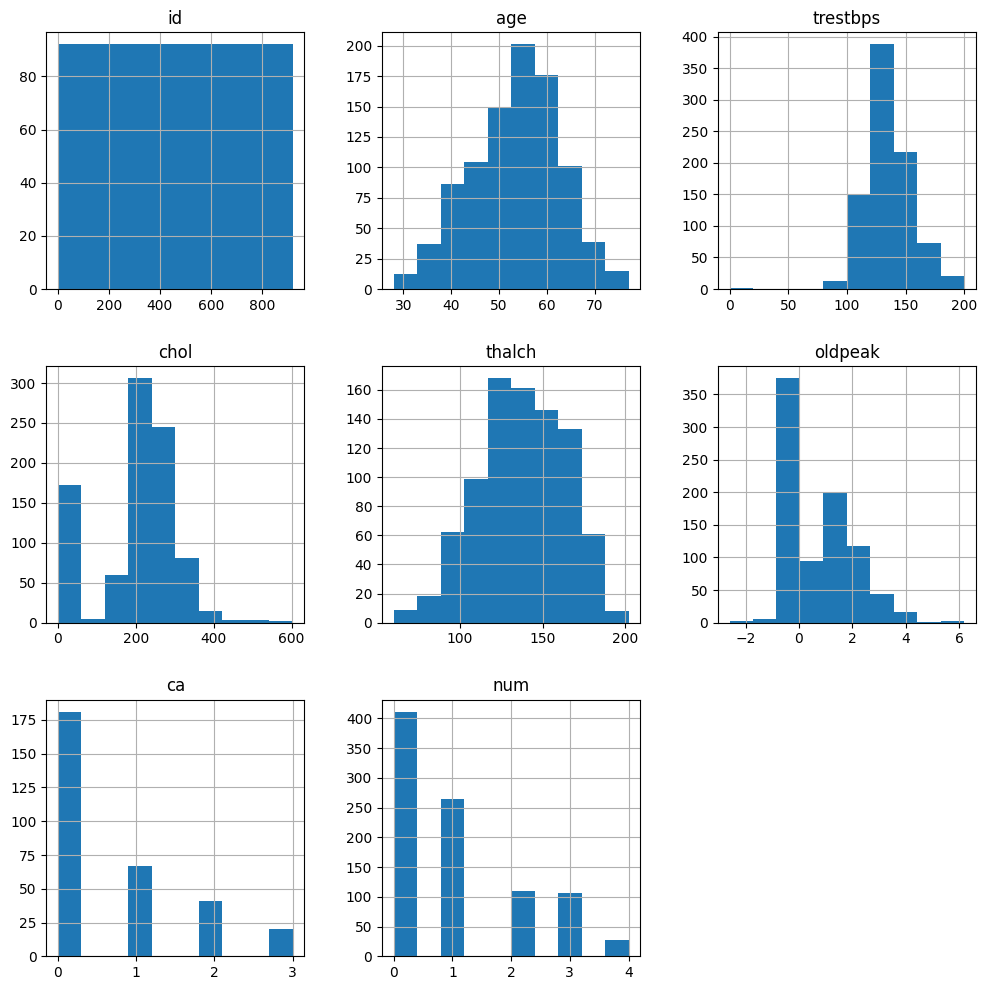

In [257]:
df.hist(figsize = (12, 12))
plt.show()

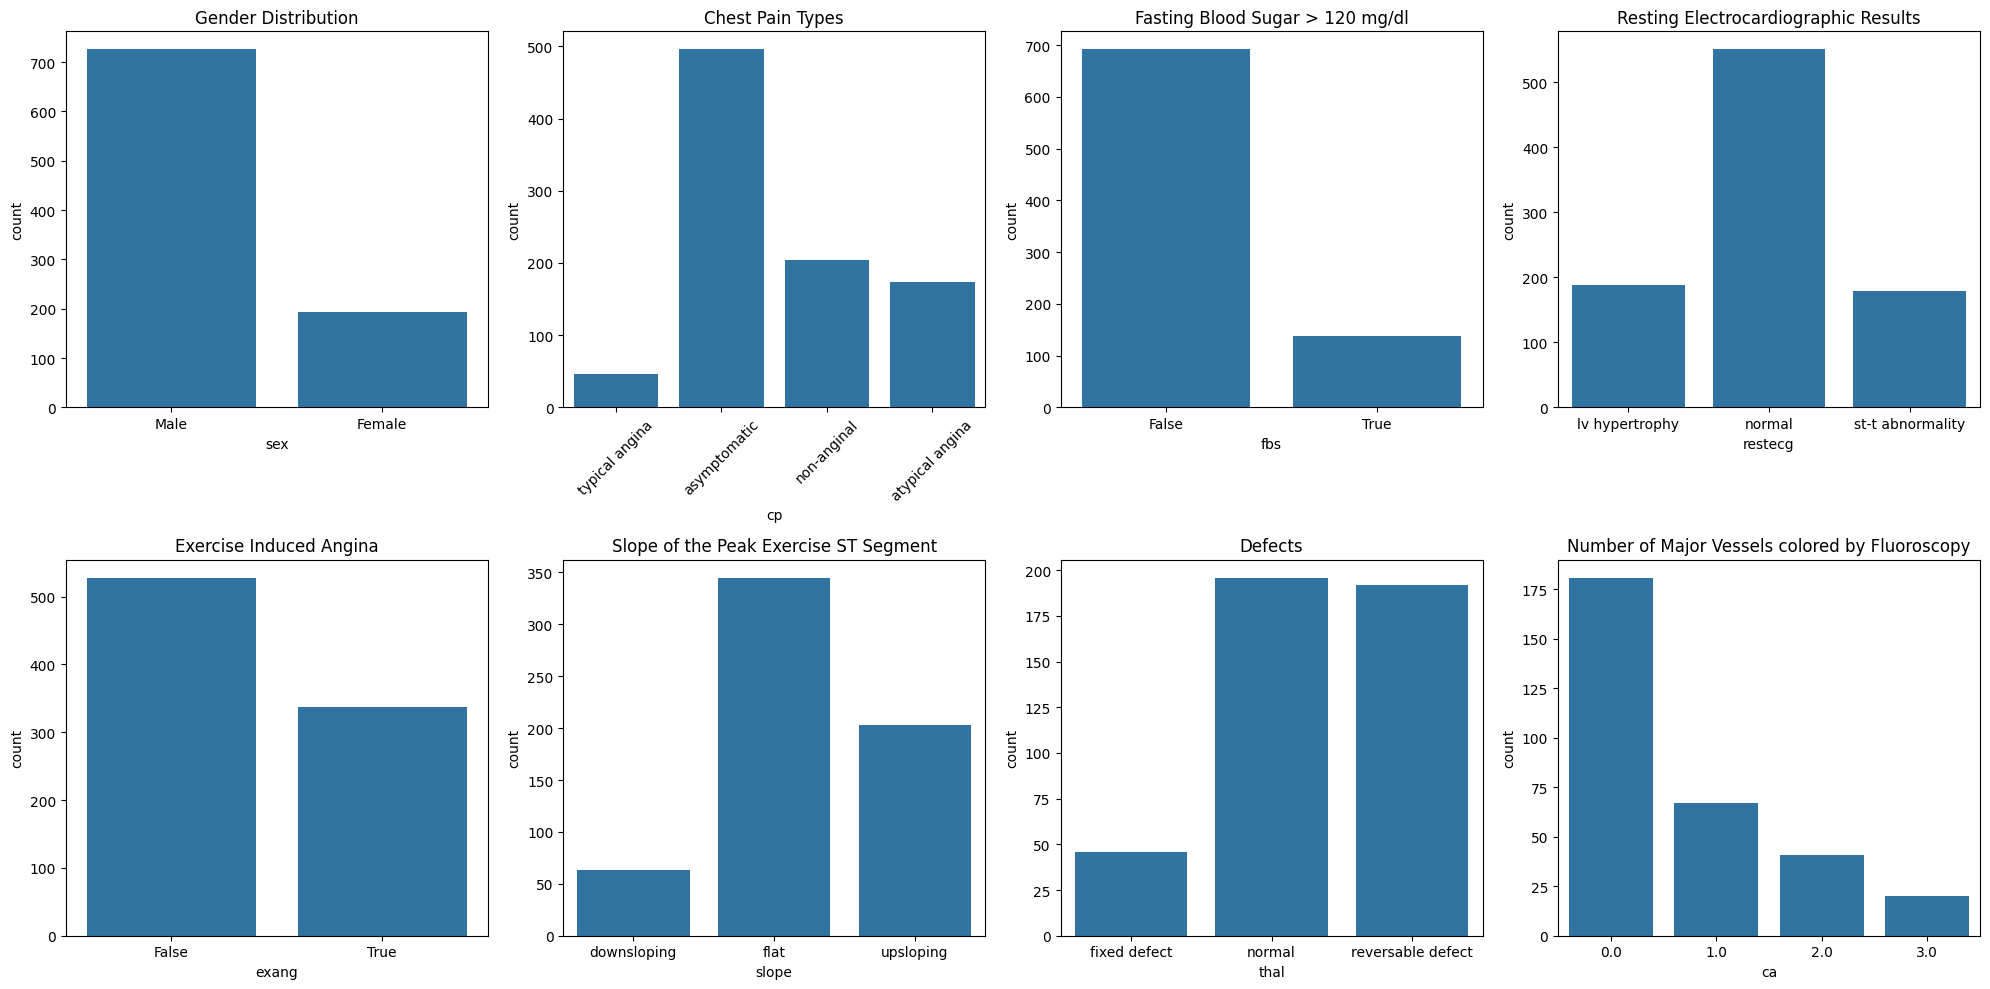

In [258]:
# Separate numeric and categorical variables for visualization purposes
CATEGORICAL_COLS = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca']
NUMERICAL_COLS = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

heart_cat = df[CATEGORICAL_COLS]
heart_num = df[NUMERICAL_COLS]


# Visualize the distribution of categorical variables 
fig, axes = plt.subplots(2, 4, figsize=(20,10))

sns.countplot(x='sex', data=heart_cat, ax=axes[0,0])
axes[0,0].set_title('Gender Distribution')

sns.countplot(x='cp', data=heart_cat, ax=axes[0,1])
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_title('Chest Pain Types')

sns.countplot(x='fbs', data=heart_cat, ax=axes[0,2])
axes[0,2].set_title('Fasting Blood Sugar > 120 mg/dl')

sns.countplot(x='restecg', data=heart_cat, ax=axes[0,3])
axes[0,3].set_title('Resting Electrocardiographic Results')

sns.countplot(x='exang', data=heart_cat, ax=axes[1,0])
axes[1,0].set_title('Exercise Induced Angina')

sns.countplot(x='slope', data=heart_cat, ax=axes[1,1])
axes[1,1].set_title('Slope of the Peak Exercise ST Segment')

sns.countplot(x='thal', data=heart_cat, ax=axes[1,2])
axes[1,2].set_title('Defects')

sns.countplot(x='ca', data=heart_cat, ax=axes[1,3])
axes[1,3].set_title('Number of Major Vessels colored by Fluoroscopy')
plt.tight_layout()
plt.show()

## Preprocess by making the num binary

In [232]:
data_copy = df.copy()

label_encoder = LabelEncoder()

# Convert text values to numbers using LabelEncoder for specified columns
text_cols = ['sex', 'dataset', 'cp', 'restecg', 'slope', 'thal']
for col in text_cols:
    data_copy[col] = label_encoder.fit_transform(data_copy[col])

# Convert True/False to binary (0/1) for specified columns
bool_cols = ['fbs', 'exang']
for col in text_cols:
    if data_copy[col].isnull().any():
        # Only convert non-missing values, leaving missing values unchanged
        data_copy[col] = data_copy[col].map({True: 1, False: 0})


# Convert 'num' column to binary
data_copy['num'] = data_copy['num'].apply(lambda x: 0 if x == 0 else 1)

# Display the modified data
data_copy[:10]

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,1,0,3,145.0,233.0,True,0,150.0,False,2.3,0,0.0,0,0
1,2,67,1,0,0,160.0,286.0,False,0,108.0,True,1.5,1,3.0,1,1
2,3,67,1,0,0,120.0,229.0,False,0,129.0,True,2.6,1,2.0,2,1
3,4,37,1,0,2,130.0,250.0,False,1,187.0,False,3.5,0,0.0,1,0
4,5,41,0,0,1,130.0,204.0,False,0,172.0,False,1.4,2,0.0,1,0
5,6,56,1,0,1,120.0,236.0,False,1,178.0,False,0.8,2,0.0,1,0
6,7,62,0,0,0,140.0,268.0,False,0,160.0,False,3.6,0,2.0,1,1
7,8,57,0,0,0,120.0,354.0,False,1,163.0,True,0.6,2,0.0,1,0
8,9,63,1,0,0,130.0,254.0,False,0,147.0,False,1.4,1,1.0,2,1
9,10,53,1,0,0,140.0,203.0,True,0,155.0,True,3.1,0,0.0,2,1


In [272]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(
    max_depth=20,  
    min_samples_split=5,  
    min_samples_leaf=10,  
    criterion='gini'  
)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.7888888888888889
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.80        49
           1       0.76      0.78      0.77        41

    accuracy                           0.79        90
   macro avg       0.79      0.79      0.79        90
weighted avg       0.79      0.79      0.79        90



In [273]:
df.shape

(299, 16)

In [260]:
## Drop NAN columns
df.dropna(axis=0, inplace=True)
data_copy = df.copy()


In [261]:
df.shape

(299, 16)

In [242]:
label_encoder = LabelEncoder()

# Convert text values to numbers using LabelEncoder for specified columns
text_cols = ['sex', 'dataset', 'cp', 'restecg', 'slope', 'thal']
for col in text_cols:
    data_copy[col] = label_encoder.fit_transform(data_copy[col])

# Convert True/False to binary (0/1) for specified columns
bool_cols = ['fbs', 'exang']
for col in bool_cols:
    data_copy[col] = data_copy[col].astype(int)

# Convert 'num' column to binary
data_copy['num'] = data_copy['num'].apply(lambda x: 0 if x == 0 else 1)

# Display the modified data
data_copy[:10]

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,1,0,3,145.0,233.0,1,0,150.0,0,2.3,0,0.0,0,0
1,2,67,1,0,0,160.0,286.0,0,0,108.0,1,1.5,1,3.0,1,1
2,3,67,1,0,0,120.0,229.0,0,0,129.0,1,2.6,1,2.0,2,1
3,4,37,1,0,2,130.0,250.0,0,1,187.0,0,3.5,0,0.0,1,0
4,5,41,0,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0.0,1,0
5,6,56,1,0,1,120.0,236.0,0,1,178.0,0,0.8,2,0.0,1,0
6,7,62,0,0,0,140.0,268.0,0,0,160.0,0,3.6,0,2.0,1,1
7,8,57,0,0,0,120.0,354.0,0,1,163.0,1,0.6,2,0.0,1,0
8,9,63,1,0,0,130.0,254.0,0,0,147.0,0,1.4,1,1.0,2,1
9,10,53,1,0,0,140.0,203.0,1,0,155.0,1,3.1,0,0.0,2,1


In [243]:
categorical_columns = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

X = data_copy.drop(['id', 'num'], axis=1)
y = np.array(data_copy['num']).reshape(-1, 1)

encoder = OneHotEncoder(sparse=False, drop='first')
X_encoded = encoder.fit_transform(X[categorical_columns])
X.drop(categorical_columns, axis=1, inplace=True)
X = np.concatenate((X.values, X_encoded), axis=1)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [244]:

y = np.array(data_copy['num']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=150, batch_size=8, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')




Epoch 1/150
27/27 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.7464 - val_loss: 0.5382 - val_accuracy: 0.8222
Epoch 2/150
27/27 [==============================] - 0s 1ms/step - loss: 0.4892 - accuracy: 0.8278 - val_loss: 0.4436 - val_accuracy: 0.8556
Epoch 3/150
27/27 [==============================] - 0s 1ms/step - loss: 0.4196 - accuracy: 0.8421 - val_loss: 0.3949 - val_accuracy: 0.8556
Epoch 4/150
27/27 [==============================] - 0s 1ms/step - loss: 0.3808 - accuracy: 0.8469 - val_loss: 0.3707 - val_accuracy: 0.8556
Epoch 5/150
27/27 [==============================] - 0s 1ms/step - loss: 0.3536 - accuracy: 0.8660 - val_loss: 0.3592 - val_accuracy: 0.8556
Epoch 6/150
27/27 [==============================] - 0s 1ms/step - loss: 0.3338 - accuracy: 0.8708 - val_loss: 0.3539 - val_accuracy: 0.8444
Epoch 7/150
27/27 [==============================] - 0s 1ms/step - loss: 0.3200 - accuracy: 0.8708 - val_loss: 0.3500 - val_accuracy: 0.8556
Epoch 8/150
2

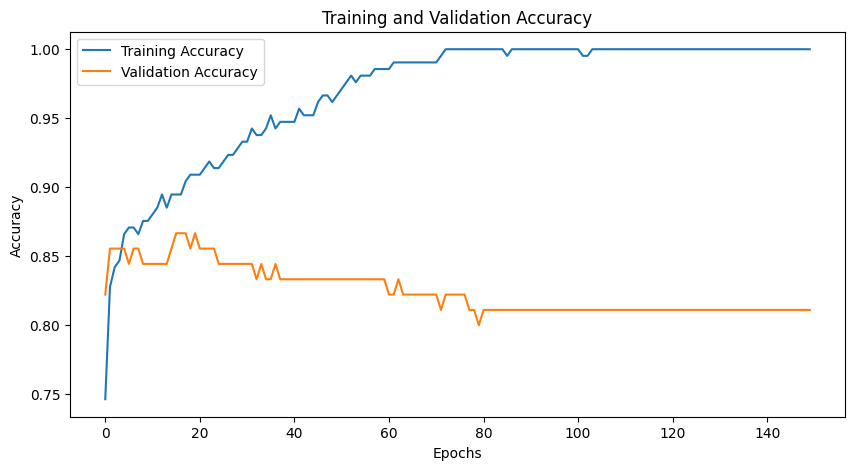

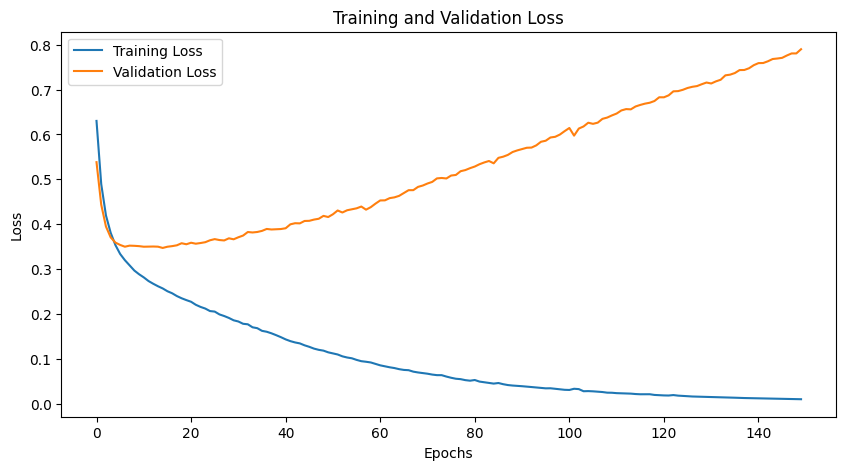

In [245]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [246]:



# Separate features and target variable
y = np.array(data_copy['num']).reshape(-1, 1)
X = data_copy.drop(['id','num'], axis=1)  # Features

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')


Epoch 1/150
27/27 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5742 - val_loss: 0.6801 - val_accuracy: 0.6778
Epoch 2/150
27/27 [==============================] - 0s 1ms/step - loss: 0.6690 - accuracy: 0.7368 - val_loss: 0.6565 - val_accuracy: 0.8000
Epoch 3/150
27/27 [==============================] - 0s 1ms/step - loss: 0.6384 - accuracy: 0.7703 - val_loss: 0.6134 - val_accuracy: 0.8222
Epoch 4/150
27/27 [==============================] - 0s 1ms/step - loss: 0.5891 - accuracy: 0.7990 - val_loss: 0.5598 - val_accuracy: 0.8444
Epoch 5/150
27/27 [==============================] - 0s 1ms/step - loss: 0.5528 - accuracy: 0.8325 - val_loss: 0.5112 - val_accuracy: 0.8556
Epoch 6/150
27/27 [==============================] - 0s 1ms/step - loss: 0.4965 - accuracy: 0.8565 - val_loss: 0.4596 - val_accuracy: 0.8556
Epoch 7/150
27/27 [==============================] - 0s 1ms/step - loss: 0.4370 - accuracy: 0.8565 - val_loss: 0.4167 - val_accuracy: 0.8444
Epoch 8/150
2

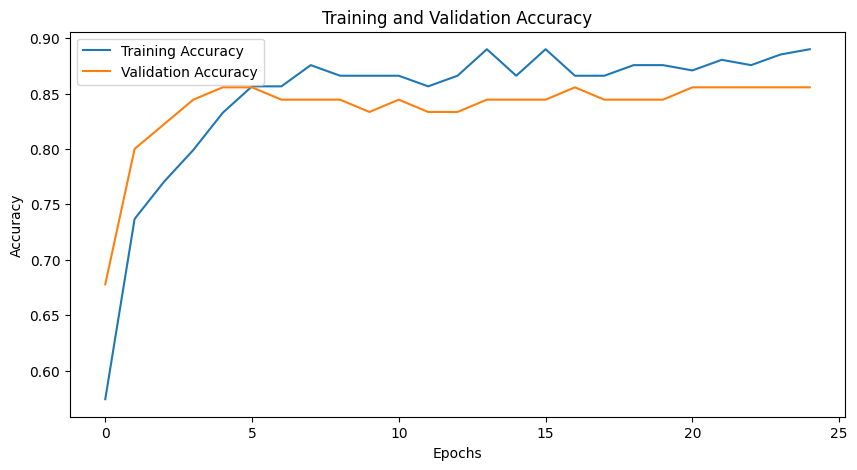

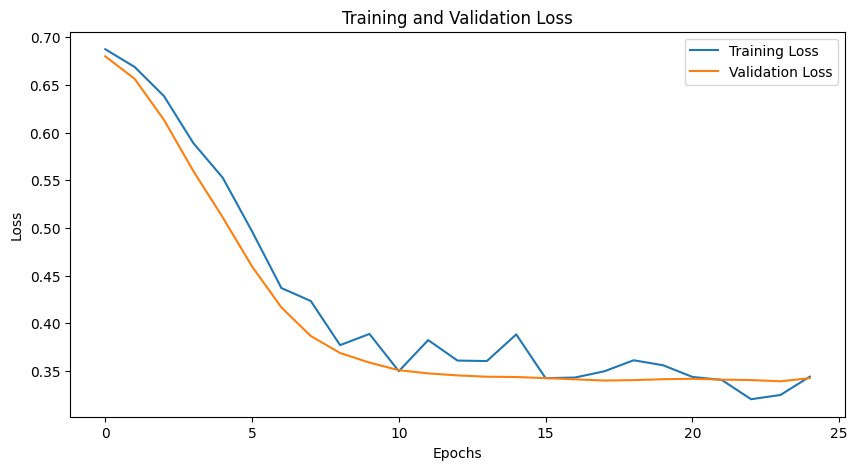

In [247]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [91]:

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

# Predict probabilities for test set
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int)  # Applying threshold (0.5 for binary classification)

# Calculate precision and recall
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)

print(f'Precision: {precision}')
print(f'Recall: {recall}')


3/3 [==============================] - 0s 2ms/step - loss: 0.3588 - accuracy: 0.8667
Test accuracy: 0.8666666746139526
3/3 [==============================] - 0s 814us/step
Precision: 0.8717948717948718
Recall: 0.8292682926829268


In [63]:
feature_names = data_copy.columns.tolist()
X_train.shape


(209, 14)

In [274]:
def model_predict(data_asarray):
    return model.predict(data_asarray)

explainer = shap.KernelExplainer(model_predict, X_train)
shap_values = explainer.shap_values(X_test)

7/7 [==============================] - 0s 679us/step


Using 209 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/90 [00:00<?, ?it/s]

13559/13559 [==============================] - 4s 297us/step


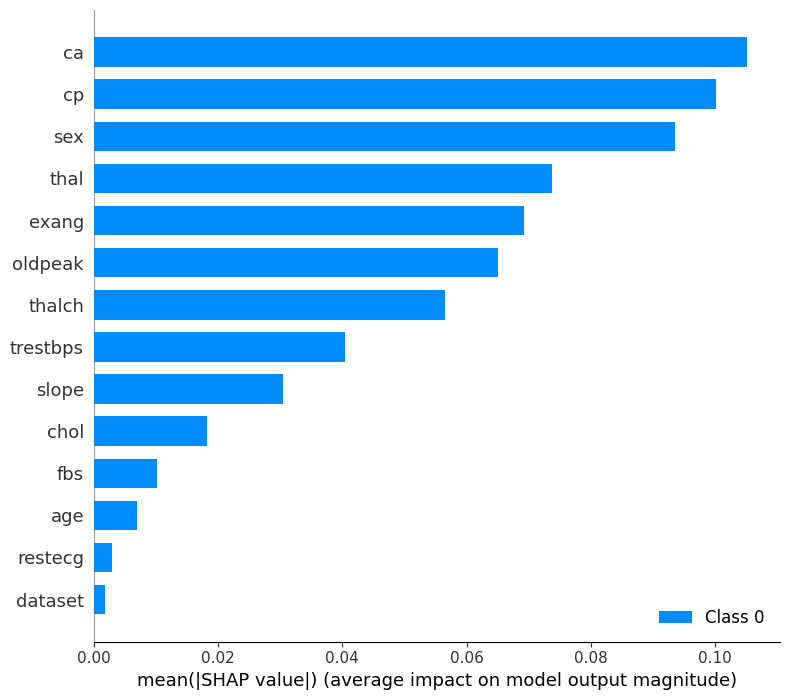

In [82]:
# Visualize SHAP values
shap.summary_plot(shap_values, X_test, feature_names=feature_names[1:-1])
shap.initjs()

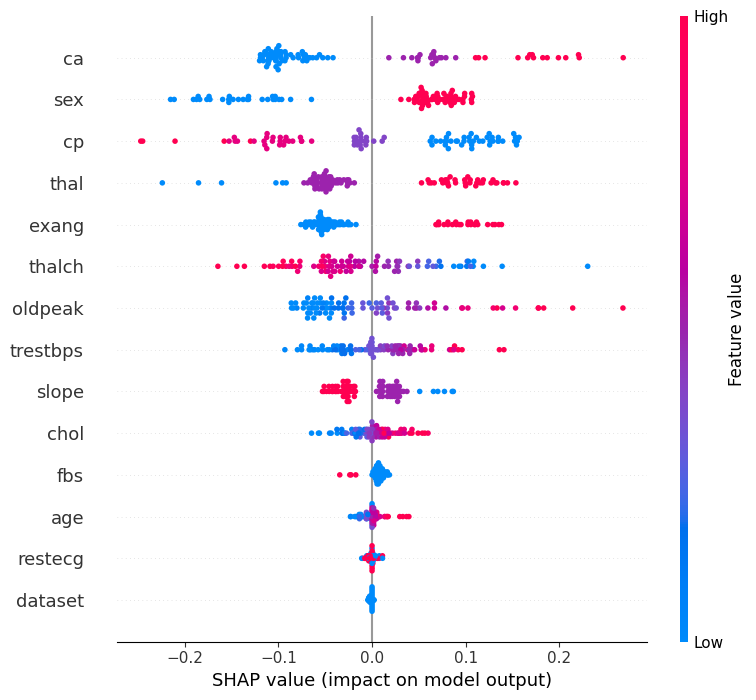

In [45]:
shap.summary_plot(shap_values[0], X_test, feature_names=feature_names[1:-1])

In [64]:
# show precision, recall and confusion matrix


['id',
 'age',
 'sex',
 'dataset',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalch',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'num']

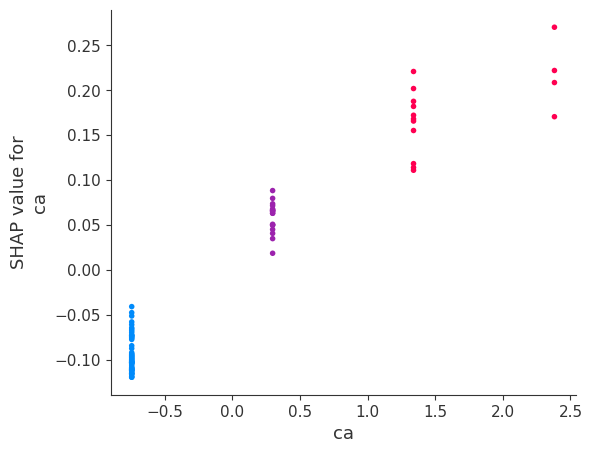

In [68]:
shap.dependence_plot('ca',shap_values[0], X_test,feature_names=feature_names[1:-1], interaction_index='ca')


In [81]:
import shap
import numpy as np

# Assuming 'model' is your trained model
# Convert your numpy array back to a pandas DataFrame for compatibility with SHAP
X_train_df = pd.DataFrame(X_train, columns=X.columns)


# Calculate SHAP values for a sample of data (e.g., the first 100 rows)
shap_values = explainer.shap_values(X_train_df.iloc[:100, :])

# Plot the SHAP force plot for a specific instance (e.g., the first instance)
shap.force_plot(explainer.expected_value, shap_values[0], X_train_df.iloc[0, :])


  0%|          | 0/100 [00:00<?, ?it/s]

13559/13559 [==============================] - 5s 379us/step


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed